# Subset Selection

Two reasons why we are not satisfied with the least squares prediction:

   * Prediction accuracy: the prediction sometimes have low bias but large variance. Setting some coefficients to zero can sometimes improve the prediction accuracy.
   
   * Interpretation: large number of predictors is confusing. Sometimes we would like to find a smaller subset of predictors that has the strongest effect.
   
There are a number of methods to perform subset selections, for example:

   * Best-Subset Selection
   * Forward-Stepwise Selection
   * Backward-Stepwise Selection

#### Dataset
We use *Prostate Cancer* Dataset to test our implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import tqdm
from itertools import combinations
from ml_datasets.esl import ProstateCancer
from esl.utils import scale
from esl.chapter03 import LeastSquaresRegression

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

In [4]:
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

##### Scaling

In [5]:
df_x = df_x.apply(lambda x: scale(x))

In [6]:
x_train = df_x[train_test=='T'].values
y_train =  df_y[train_test=='T'].values

x_test = df_x[train_test=='F'].values
y_test =  df_y[train_test=='F'].values

#### 3.3.1 Best-Subset Selection

This method finds for each $k\in {0, 1, 2, \cdots, p}$ the subset of size $k$ that gives the smallest residual sum of squares.

It works by evaluating a set of models built from all possible combination of $k$ features. This is possibly best illustrated by the following pseudo code with an example:

<pre><code>Train a model M<sub>0</sub> using only the intercept as the feature
Suppose we have three features (p=3).
For k in [1, 2, 3]
    generate combinations of k features. As an example for k=2, the combinations are: [1, 2], [1, 3], [2, 3]    
    fit models using these combinations    
    find the best model M<sub>k</sub> that gives the lowest error, e.g., RSS
</code></pre>

This algorithm is implemented as a method called `process_subset_best`. 

Once we get a set of best models for all $k$, we can select the best overall model using some useful statistics such as *AIC*, *BIC*, *Mallow's Cp*, etc. Since we need to search through all possible subsets of features, this algorithm is feasible for limited number of parameters.

#### 3.3.2 Forward- and Backward-Stepwise Selection
Rather that search through all possible subsets of features, we can seek a good path through them. 

The **forward-stepwise** selection starts with the intercept then sequentially adds into the model the predictor that most improves the fit. This algorithm is illustrated as below:
<pre><code>Train a model M<sub>0</sub> using only the intercept as the feature
Suppose we have three features (p=3).
Initialize a set of remaining features f<sub>r</sub> = [1, 2, 3]
Initialize a set of features to keep f<sub>k</sub>= []
For k in [1, 2, 3]
    generate combinations of features by appending a feature from f<sub>r</sub> with f<sub>k</sub> 
    fit models using these combinations
    find the best model M<sub>k</sub> that gives the lowest error, e.g., RSS
    add the element of f<sub>r</sub> that produces the best M<sub>k</sub> to f<sub>k</sub>
    remove the element of f<sub>r</sub> that produces the best M<sub>k</sub> from f<sub>r</sub>
</code></pre>

This algorithm is implemented as a method called `process_subset_forward`. Then we can use the same statistics as before to get the best overall model.

The **backward-stepwise** selection starts with the full features then sequentially removes from the model the predictor that most improves the fit. This algorithm is illustrated as below:
<pre><code>Initialize a set of best features f<sub>f</sub> = [1, 2, 3]
Train a model M<sub>p</sub> using f<sub>f</sub>
Suppose we have three features (p=3).
Initialize a set of best features f<sub>b</sub> = f<sub>f</sub> = [1, 2, 3]
For k in [1, 2, 3]
    generate combinations of (len(f<sub>f</sub>) - 1) features from f<sub>b</sub> 
    fit models using these combinations
    find the best model M<sub>k</sub> that gives the lowest error, e.g., RSS
    assign the combination that produces the best M<sub>k</sub> as f<sub>b</sub>
</code></pre>

This algorithm is implemented as a method called `process_subset_backward`. Then we can use the same statistics as before to get the best overall model.

#### 3.3.4 Prostate Cancer Data Example

Here, we try to apply the subset selection methods to the *Prostate Cancer* dataset. We wrap the three mentioned methods in a class called *SubsetSelection*.

This class contains several methods:

   * `fit`: to fit the model using the least squares algorithm (similar to the one in Chapter 2). In here, we'll obtain $\hat\beta$.
   * `process_subset_best`: to find the best subset using the best selection method.
   * `process_subset_forward`: to find the best subset using the forward-stepwise selection method.
   * `process_subset_backward`: to find the best subset using the backward-stepwise selection method.
   * `run`: to run the subset selection algoritms using our dataset. It takes `mode` (`best`, `forward`, `backward`) as an argument.
   * `get_statistics`: to get the statistics ($Mallow's C_p$, $AIC$, $BIC$) from the $k$ best models. This method calls `get_mallow_cp`, `get_aic`, and `get_bic`.
   * `get_mallow_cp`: it calculates the `Mallow's Cp` statistic using the following equation:
   $$C_p = \frac{1}{m} (RSS + 2d\hat\sigma^2)$$
   
       where $m$ is the number of datapoints, $d$ is the number of features used, and $\hat\sigma^2$ is given as:
       $$\hat\sigma^2 = \frac{RSS}{m-p-1}$$
   
       here, $RSS$ is the $RSS$ generated from the full model with $p$ features. 
       
   * `get_aic`: it calculates the `AIC` statistic using the following equation:
       $$AIC = \frac{1}{m\hat\sigma^2} (RSS + 2d\hat\sigma^2)$$
       
   * `get_bic`: it calculates the `BIC` statistic using the following equation:
       $$BIC = \frac{1}{m\hat\sigma^2} (RSS + \log(m)2d\hat\sigma^2)$$

The following is the complete `SubsetSelection` class:

In [7]:
class SubsetSelection:
    def __init__(self, *args, **kwargs):
        self.subsets = kwargs.get("subsets", None)

    def fit(self, feature_index):
        if feature_index:
            x_temp = self.x[:, feature_index].reshape(-1, len(feature_index))

        else:
            x_temp = np.zeros_like(self.x[:, 0]).reshape(-1, 1)
            x_temp[:, 0] = np.nan

        lsqr = LeastSquaresRegression()
        lsqr.fit(x_temp, self.y)

        return lsqr.RSS(x_temp, self.y)

    def process_subset_best(self):
        result = dict()
        result["num_feat"] = []
        result["feat_subset"] = []
        result["RSS"] = []
        
        for subset_size in range(len(self.subsets) + 1):
            subset = combinations(self.subsets, subset_size)
            subset = [list(i) for i in subset]
            best_RSS = np.inf
            if any(subset):
                for feature_index in tqdm(
                    subset,
                    total=len(subset),
                    desc="processing Best subset: {}".format(subset_size),
                ):
                    RSS_temp = self.fit(feature_index)
     
                    result["RSS"].append(RSS_temp)
                    result["feat_subset"].append(feature_index)
                    result["num_feat"].append(subset_size)
            else:

                result["RSS"].append(self.fit(None))
                result["feat_subset"].append("intercept")
                result["num_feat"].append(0)
        
        result = pd.DataFrame(result)
        result_best = result[result.groupby('num_feat')['RSS'].transform(min) == result['RSS']]
       
        return result, result_best.reset_index(drop=True)
    
    def process_subset_forward(self):
        result = dict()
        result["num_feat"] = []
        result["feat_subset"] = []
        result["RSS"] = []
        
        subsets_remaining = list(self.subsets)
        
        subsets_keep = []
        for subset_size in range(len(self.subsets) + 1):
            subset = combinations(subsets_remaining, 1)
            subset = [list(i) for i in subset]
            best_RSS = np.inf

            if subset_size != 0:
                for feature_index in tqdm(
                    subset,
                    total=len(subset),
                    desc="processing Forward subset: {}".format(subset_size),
                ):
                    idx_temp = subsets_keep + feature_index
                    RSS_temp = self.fit(idx_temp)
                    
                    if RSS_temp < best_RSS:
                        best_RSS = RSS_temp
                        best_feature = feature_index[0]

                subsets_keep.append(best_feature)
                subsets_remaining.remove(best_feature)
                result["RSS"].append(best_RSS)
                
                subsets_keep_copy = np.sort(subsets_keep.copy())
                result["feat_subset"].append(subsets_keep_copy)
                result["num_feat"].append(subset_size)

            else:
                result["RSS"].append(self.fit(None))
                result["feat_subset"].append('intercept')
                result["num_feat"].append(0)
        
        result = pd.DataFrame(result)
        return result.reset_index(drop=True)
    
    def process_subset_backward(self):
        result = dict()
        result["num_feat"] = []
        result["feat_subset"] = []
        result["RSS"] = []
        
        best_feature = list(self.subsets)

        for subset_size in range(len(self.subsets) + 1):
            subset = combinations(best_feature, len(list(self.subsets)) - subset_size)
            subset = [list(i) for i in subset]
            best_RSS = np.inf
            
            if len(list(self.subsets)) - subset_size != 0:
                for feature_index in tqdm(
                    subset,
                    total=len(subset),
                    desc="processing Backward subset: {}".format(subset_size),
                ):
                    RSS_temp = self.fit(list(feature_index))
                    
                    if RSS_temp < best_RSS:
                        best_RSS = RSS_temp
                        best_feature = feature_index
                                                     
                result["RSS"].append(best_RSS)
                result["feat_subset"].append(best_feature)
                result["num_feat"].append(len(best_feature))

            else:
                result["RSS"].append(self.fit(None))
                result["feat_subset"].append('intercept')
                result["num_feat"].append(0)
        
        result = pd.DataFrame(result).sort_values(by=['num_feat'], ascending=False)
        return result.reset_index(drop=True)
    
    def run(self, x, y , mode='best'):
        if self.subsets is not None:
            self.x = x
            self.y = y
            
            if mode == 'best':
                return self.process_subset_best()
            
            elif mode == 'forward':
                return self.process_subset_forward()
            
            elif mode == 'backward':
                return self.process_subset_backward()
            
            else:
                print('Incorrect mode selection, available: best, forward, backward')
                

        else:
            print("Subsets need to be defined!")
            sys.exit()
    
    def get_statistics(self, result):
        result = self.get_mallow_cp(result)
        result = self.get_aic(result)
        result = self.get_bic(result)
        return result
        
        
    def get_mallow_cp(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p)) * min(result['RSS'])
        result["Mallow's Cp"] = (1 / m) * (result['RSS'] + 2 * result["num_feat"] * sigma_hat_squared) 
        return result
        
    def get_aic(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p -1)) * min(result['RSS'])
        result["AIC"] = (1 / (m * sigma_hat_squared)) * (result['RSS'] + 2 * result["num_feat"] * sigma_hat_squared) 
        return result
        
    def get_bic(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p -1)) * min(result['RSS'])
        result["BIC"] = (1 / (m * sigma_hat_squared)) * (result['RSS'] + np.log(m) * result["num_feat"] * sigma_hat_squared) 
        return result

Now, we use this class to generate subsets using the three methods.

First, we initialize the class:

In [8]:
subset = SubsetSelection(subsets=np.arange(x_train.shape[1]))

Generate subsets using best selection method:

In [9]:
result_bs, result_bs_best = subset.run(x_train, y_train, mode='best')

processing Best subset: 8: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


Plot the results to generate Figure 3.5

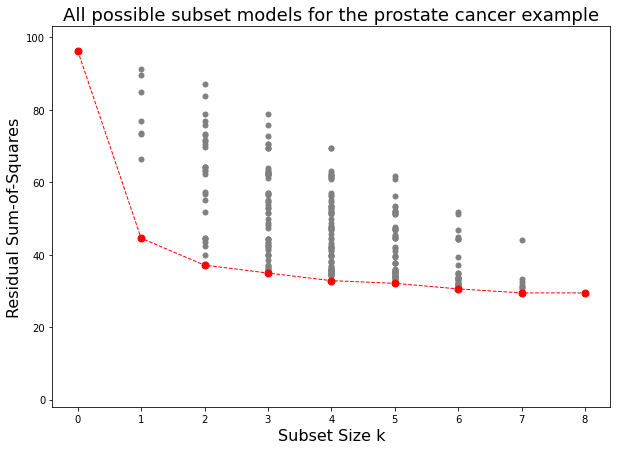

In [10]:
plt.figure(figsize=(10, 7))
plt.title('All possible subset models for the prostate cancer example', fontsize=18)
plt.plot(result_bs['num_feat'], result_bs['RSS'], 'o', color='grey', markersize=5)
plt.plot(result_bs_best['num_feat'], result_bs_best['RSS'], 'r--o', markersize=7, mfc='red', lw=1)
plt.ylim([-2, 103])
plt.xlabel('Subset Size k', fontsize=16)
plt.ylabel('Residual Sum-of-Squares', rotation=90, fontsize=16)
plt.show()

Generate subsets using forward-stepwise selection method:

In [11]:
result_fw_step = subset.run(x_train, y_train, mode='forward')

processing Forward subset: 8: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.22it/s]


Generate subsets using backward-stepwise selection method:

In [12]:
result_bw_step = subset.run(x_train, y_train, mode='backward')

processing Backward subset: 7: 100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 1005.23it/s]


According to the book, on the prostate cancer example, best-subset, forward and backward selection all gave exactly the same sequence of terms.

Let us make sure that this is the case:

In [13]:
print('BEST')
result_bs_best

BEST


,num_feat,feat_subset,RSS
0,0,intercept,96.281445
1,1,[0],44.528583
2,2,"[0, 1]",37.091846
3,3,"[0, 1, 4]",34.907749
4,4,"[0, 1, 3, 4]",32.814995
5,5,"[0, 1, 3, 4, 7]",32.069447
6,6,"[0, 1, 3, 4, 5, 7]",30.539778
7,7,"[0, 1, 2, 3, 4, 5, 7]",29.437300
8,8,"[0, 1, 2, 3, 4, 5, 6, 7]",29.426384


In [14]:
print('FORWARD')
result_fw_step

FORWARD


,num_feat,feat_subset,RSS
0,0,intercept,96.281445
1,1,[0],44.528583
2,2,"[0, 1]",37.091846
3,3,"[0, 1, 4]",34.907749
4,4,"[0, 1, 3, 4]",32.814995
5,5,"[0, 1, 3, 4, 7]",32.069447
6,6,"[0, 1, 3, 4, 5, 7]",30.539778
7,7,"[0, 1, 2, 3, 4, 5, 7]",29.437300
8,8,"[0, 1, 2, 3, 4, 5, 6, 7]",29.426384


In [15]:
print('BACKWARD')
result_bw_step

BACKWARD


,num_feat,feat_subset,RSS
0,8,"[0, 1, 2, 3, 4, 5, 6, 7]",29.426384
1,7,"[0, 1, 2, 3, 4, 5, 7]",29.437300
2,6,"[0, 1, 3, 4, 5, 7]",30.539778
3,5,"[0, 1, 3, 4, 7]",32.069447
4,4,"[0, 1, 3, 4]",32.814995
5,3,"[0, 1, 4]",34.907749
6,2,"[0, 1]",37.091846
7,1,[0],44.528583
8,0,intercept,96.281445


As we can see, best-subset, forward and backward selection all gave exactly the same sequence of terms.

**NOTE**: I did not try these methods on the simulated data as presented in the book since running best-selection method for $p=30$ is just unbearable. Therefore, we just implemented these methods on the *Prostate Cancer* dataset as given in section 3.3.4.